In [1]:
from petsc4py import PETSc
from mpi4py import MPI

import ufl

import dolfinx
from dolfinx import fem, mesh
import dolfinx.fem.petsc

# print version (to search the right documentation)
print(f"DOLFINx version: {dolfinx.__version__}")

DOLFINx version: 0.9.0


In [2]:
import math
import gmsh
from dolfinx.io.gmshio import model_to_mesh

gmsh.initialize()

# create model
gmsh.model.add("plate")

# geometrical parameters
L = 0.05
R = 0.1*L

# mesh parameters
nPoints1 = 20
ratio = 0.9
nPoints2 = 20

mesh_comm = MPI.COMM_WORLD
model_rank = 0
if mesh_comm.rank == model_rank:
    # add points
    P0 = gmsh.model.geo.addPoint(0.0,0.0,0.0)
    P1 = gmsh.model.geo.addPoint(R,0.0,0.0)
    P2 = gmsh.model.geo.addPoint(L,0.0,0.0)
    P3 = gmsh.model.geo.addPoint(L,L,0.0)
    P4 = gmsh.model.geo.addPoint(0.0,L,0.0)
    P5 = gmsh.model.geo.addPoint(0.0,R,0.0)
    P6 = gmsh.model.geo.addPoint(R/math.sqrt(2.0),R/math.sqrt(2.0),0.0)

    # add lines
    L1 = gmsh.model.geo.addLine(P1,P2)
    L2 = gmsh.model.geo.addLine(P2,P3)
    L3 = gmsh.model.geo.addLine(P3,P4)
    L4 = gmsh.model.geo.addLine(P4,P5)
    L5 = gmsh.model.geo.addCircleArc(P5,P0,P6)
    L6 = gmsh.model.geo.addCircleArc(P6,P0,P1)
    L7 = gmsh.model.geo.addLine(P6,P3)

    # add contours and domains
    C1 = gmsh.model.geo.addCurveLoop([L1,L2,-L7,L6])
    S1 = gmsh.model.geo.addPlaneSurface([C1])
    C2 = gmsh.model.geo.addCurveLoop([L3,L4,L5,L7])
    S2 = gmsh.model.geo.addPlaneSurface([C2])

    # build mesh
    gmsh.model.geo.mesh.setTransfiniteCurve(L1,nPoints1,"Progression",1.0/ratio)
    gmsh.model.geo.mesh.setTransfiniteCurve(L2,nPoints2)
    gmsh.model.geo.mesh.setTransfiniteCurve(L3,nPoints2)
    gmsh.model.geo.mesh.setTransfiniteCurve(L4,nPoints1,"Progression",ratio)
    gmsh.model.geo.mesh.setTransfiniteCurve(L5,nPoints2)
    gmsh.model.geo.mesh.setTransfiniteCurve(L6,nPoints2)
    gmsh.model.geo.mesh.setTransfiniteCurve(L7,nPoints1,"Progression",1.0/ratio)
    gmsh.model.geo.mesh.setTransfiniteSurface(S1,cornerTags=[P1,P2,P3,P6])
    gmsh.model.geo.mesh.setTransfiniteSurface(S2,cornerTags=[P3,P4,P5,P6])
    gmsh.model.geo.mesh.setRecombine(2,S1)
    gmsh.model.geo.mesh.setRecombine(2,S2)
    gmsh.model.geo.synchronize()

    # tag domains
    gmsh.model.addPhysicalGroup(2,[S1,S2],1)
    gmsh.model.addPhysicalGroup(1,[L1],11)
    gmsh.model.addPhysicalGroup(1,[L2],12)
    gmsh.model.addPhysicalGroup(1,[L3],13)
    gmsh.model.addPhysicalGroup(1,[L4],14)

    # generate mesh
    gmsh.model.mesh.generate(2)
    gmsh.write("plate.msh")
    domain, cells, facets = model_to_mesh(gmsh.model, mesh_comm, model_rank, gdim=2)
gmsh.finalize()

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 20%] Meshing curve 2 (Line)
Info    : [ 30%] Meshing curve 3 (Line)
Info    : [ 50%] Meshing curve 4 (Line)
Info    : [ 60%] Meshing curve 5 (Circle)
Info    : [ 80%] Meshing curve 6 (Circle)
Info    : [ 90%] Meshing curve 7 (Line)
Info    : Done meshing 1D (Wall 0.00135725s, CPU 0.00174s)
Info    : Meshing 2D...
Info    : [  0%] Meshing surface 1 (Transfinite)
Info    : [ 60%] Meshing surface 2 (Transfinite)
Info    : Done meshing 2D (Wall 0.0017141s, CPU 0.000429s)
Info    : 781 nodes 862 elements
Info    : Writing 'plate.msh'...
Info    : Done writing 'plate.msh'


We define the functional space beforehand, for plotting reasons

In [3]:
V = dolfinx.fem.functionspace(domain,("Lagrange",1,(2,)))

Extracting the VTK mesh from the functional space, instead of using the FEniCSx mesh object, allows to specify that we are using linear interpolation (pyvista cannot handle quads of higher order) 

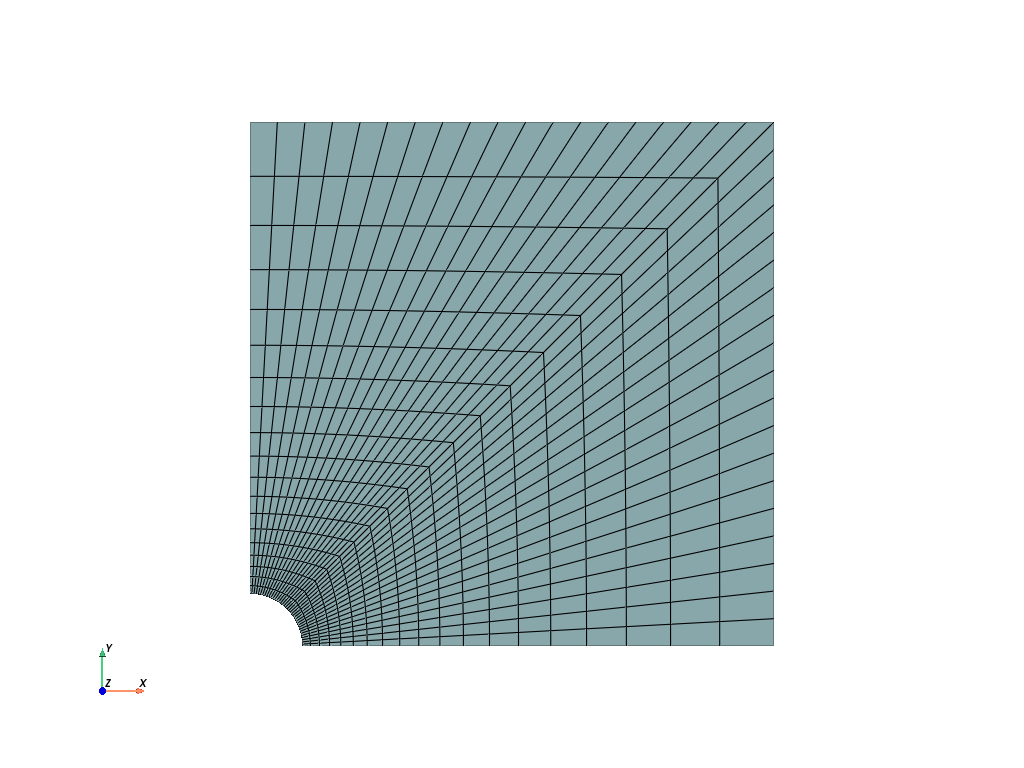

In [4]:
import pyvista
from dolfinx import plot

pyvista.set_jupyter_backend("static")

topology, cell_types, geometry = plot.vtk_mesh(V)
grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)

# Create plotter and pyvista grid
p = pyvista.Plotter()
p.add_mesh(grid, show_edges=True)
p.view_xy()
p.show_axes()
p.show()

In [5]:
# locate b.c. dofs
bottom_dofs = dolfinx.fem.locate_dofs_topological(V.sub(1),1,facets.find(11))
bc_bottom = dolfinx.fem.dirichletbc(0.0,bottom_dofs,V.sub(1))
left_dofs = dolfinx.fem.locate_dofs_topological(V.sub(0),1,facets.find(14))
bc_left = dolfinx.fem.dirichletbc(0.0,left_dofs,V.sub(0))

top_displ = 0.01*L
top_dofs = dolfinx.fem.locate_dofs_topological(V.sub(1),1,facets.find(13))
bc_top = dolfinx.fem.dirichletbc(top_displ,top_dofs,V.sub(1))

In [6]:
# define strain
def eps_2d(u):
    g = ufl.grad(u)
    return ufl.as_vector([g[0,0],g[0,1]+g[1,0],g[1,1]])

In [7]:
# material properties
E = 2.1e11
nu = 0.3
C11 = E/(1.0-nu*nu)
C12 = nu*C11
C44 = 0.5*E/(1.0+nu)

# define constitutive relation in UFL
def stress_2d(eps):
    return ufl.as_vector([C11*eps[0]+C12*eps[2],C44*eps[1],C12*eps[0]+C11*eps[2]])

In [8]:
# define linear and bilinear forms
u = ufl.TrialFunction(V)
v = ufl.TestFunction(V)

In [9]:
# define quadrature space for strains and stresses
import basix

We = basix.ufl.quadrature_element(domain.basix_cell(), value_shape=(3,), scheme="default", degree=2)
W = fem.functionspace(domain, We)